## Load libraries

In [ ]:
library(limma)
library(statmod)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(edgeR)
library(data.table)
library(readr)
library(tibble)
library(reshape2)
library(pheatmap)
library(yaml)
library(stringr)
library(ggh4x)
library(matrixStats)
library(RColorBrewer)
library(DESeq2)

## Load data

In [2]:
counts <- read.table("/path_to_counts_matrix.txt", sep = '\t', header = TRUE)
rownames(counts) <- counts$GENE
counts <- counts[-1]
colnames(counts) <- gsub("\\.", "-", colnames(counts))
head(counts)

,CW20012_NRXN1_Het_a,CW50037_NRXN1_Homo_b,CW50037_NRXN1_Homo_c,CW50037_NRXN1_Homo_d,CW20012_NRXN1_Het_b,CW20012_NRXN1_Het_c,CW20012_NRXN1_Het_d,ML898-4425_NRXN1_Homo_a,ML898-4425_NRXN1_Homo_b,ML898-4425_NRXN1_Homo_c,...,ML909-6344_NRXN1_WT_d,ML911-9779_NRXN1_Homo_a,ML911-9779_NRXN1_Homo_b,ML911-9779_NRXN1_Homo_c,ML911-9779_NRXN1_Homo_d,CW20103_NRXN1_Homo_a,CW20012_NRXN1_Homo_a,CW20012_NRXN1_Homo_b,CW20012_NRXN1_Homo_c,CW20012_NRXN1_Homo_d
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5_8S_rRNA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,0,1,0,0
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,86,14,22,13,38,26,28,25,4,33,...,1,11,9,0,14,13,34,19,28,26
A1BG-AS1,69,21,12,13,10,12,7,8,2,4,...,1,2,1,3,7,1,18,10,24,24
A1CF,4,1,1,2,1,0,0,0,1,0,...,1,1,1,0,0,0,0,0,4,0
A2M,2602,507,345,300,1417,1547,1415,498,1,278,...,25,94,282,84,676,276,1913,1350,1420,2105


In [3]:
#Remove relevant X and Y-linked genes
sex_genes <- c("DBY", "SMCY", "UTY", "RPS4Y", "USP9Y", "XIST")
counts<- counts[!rownames(counts) %in% sex_genes, ]
dim(counts)

[1] 37201   119

In [5]:
counts[is.na(counts)] <- 0

In [6]:
#Make metadata table

metadata <- data.frame(sample=colnames(counts)) 
metadata$gene <- str_to_upper(str_split_fixed(colnames(counts),"_",n=4)[,2])
metadata$donor <- str_to_upper(str_split_fixed(colnames(counts),"_",n=4)[,1])
metadata$genotype <- str_to_upper(str_split_fixed(colnames(counts),"_",n=4)[,3])
metadata$target_gt <- paste0(metadata$gene,"_",metadata$genotype)
head(metadata)

sample,gene,donor,genotype,target_gt
<chr>,<chr>,<chr>,<chr>,<chr>
ML907-2836_NRXN1_Homo_a,NRXN1,ML907-2836,HOMO,NRXN1_HOMO
ML907-2836_NRXN1_Homo_b,NRXN1,ML907-2836,HOMO,NRXN1_HOMO
ML907-2836_NRXN1_Homo_c,NRXN1,ML907-2836,HOMO,NRXN1_HOMO
ML907-2836_NRXN1_Homo_d,NRXN1,ML907-2836,HOMO,NRXN1_HOMO
ML907-2836_NRXN1_Het_a,NRXN1,ML907-2836,HET,NRXN1_HET
ML907-2836_NRXN1_Het_b,NRXN1,ML907-2836,HET,NRXN1_HET
ML907-2836_NRXN1_Het_c,NRXN1,ML907-2836,HET,NRXN1_HET
ML907-2836_NRXN1_Het_d,NRXN1,ML907-2836,HET,NRXN1_HET
ML907-2836_NRXN1_WT_a,NRXN1,ML907-2836,WT,NRXN1_WT


In [7]:
raw_metadata <- read.table("/path_to_metadata.tsv",sep="\t",header=T)
metadata$PRS <- raw_metadata[match(metadata$donor,raw_metadata$Donor),"PRS"]
metadata$sex <- raw_metadata[match(metadata$donor,raw_metadata$Donor),"Sex"]
rownames(metadata) <- NULL
head(metadata)

sample,gene,donor,genotype,target_gt,PRS,sex
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ML907-2836_NRXN1_Homo_a,NRXN1,ML907-2836,HOMO,NRXN1_HOMO,NEUTRAL,Female
ML907-2836_NRXN1_Homo_b,NRXN1,ML907-2836,HOMO,NRXN1_HOMO,NEUTRAL,Female
ML907-2836_NRXN1_Homo_c,NRXN1,ML907-2836,HOMO,NRXN1_HOMO,NEUTRAL,Female
ML907-2836_NRXN1_Homo_d,NRXN1,ML907-2836,HOMO,NRXN1_HOMO,NEUTRAL,Female
ML907-2836_NRXN1_Het_a,NRXN1,ML907-2836,HET,NRXN1_HET,NEUTRAL,Female
ML907-2836_NRXN1_Het_b,NRXN1,ML907-2836,HET,NRXN1_HET,NEUTRAL,Female
ML907-2836_NRXN1_Het_c,NRXN1,ML907-2836,HET,NRXN1_HET,NEUTRAL,Female
ML907-2836_NRXN1_Het_d,NRXN1,ML907-2836,HET,NRXN1_HET,NEUTRAL,Female
ML907-2836_NRXN1_WT_a,NRXN1,ML907-2836,WT,NRXN1_WT,NEUTRAL,Female


In [8]:
names(counts) <- sub("\\-","",names(counts))
metadata$donor <- sub("\\-","",metadata$donor)
metadata$sample <- sub("\\-","",metadata$sample)
metadata[is.na(metadata$PRS),"PRS"] <- "NEUTRAL"
head(metadata)

In [ ]:
#Plot library size

get_library_size <- function(count_data) {
  df <- as.data.frame(count_data)
  
  long_df <- df %>% 
    pivot_longer(cols = everything(), names_to = "sample", values_to = "reads")
  
  #Remove replicate indicators
  long_df$sample <- gsub("_a|_b|_c|_d|_e|_f$", "", long_df$sample)
  
  #Aggregate by new sample names
  aggregated_df <- long_df %>% 
    group_by(sample) %>%
    summarise(total_reads = sum(reads, na.rm = TRUE))

  aggregated_df$donor <- sub("_.*", "", aggregated_df$sample)
  aggregated_df$genotype <- sub(".*_", "", aggregated_df$sample)


  
  return(aggregated_df)
}

#Library size bar graph

lib_size_bar <- function(library_data) {
  #Extract donor and genotype from sample name
  if (!"donor" %in% names(library_data)) {
    library_data$donor <- sub("_.*", "", library_data$sample)
    library_data$genotype <- sub(".*_(.*)$", "\\1", library_data$sample)
  }

  library_data$donor_genotype <- with(library_data, paste(donor, genotype, sep = "_"))

  #Custom order for genotypes
  genotype_order <- c("WT", "Het", "Homo")
  
  #Sorting index based on the donor and then the custom genotype order
  library_data <- library_data %>%
    mutate(
      donor_genotype = factor(donor_genotype, levels = unique(donor_genotype[order(donor, match(genotype, genotype_order))]))
    )

  #Plot
  lib_size <- ggplot(library_data, aes(x = donor_genotype, y = total_reads, fill = donor)) +
    geom_bar(stat = "identity") +
    labs(title = "Library Size per Sample", x = "Sample", y = "Counts") +
    scale_fill_brewer(palette = "Set3", name = "Donor") +
    scale_x_discrete(labels = function(x) stringr::str_wrap(x, width = 10)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, size = 8))

  return(lib_size)
}

library_data <- get_library_size(counts)
lib_bar <- lib_size_bar(library_data)
lib_bar

# Run differential expression

In [12]:
make_donor_contrasts <- function(design,dge) {

    #get one contrast
    getOneContrast <- function(idx, dge, samples) {
        d <- dge$samples[idx,]$donor
        controls <- samples[grep(paste0(d,"NRXN1_WT"), samples)] #use NRXN1_WT as control
        treats <- dge$samples[idx,]$group
        if (length(treats)>0 & length(controls)>0 & (!treats %like% "NRXN1_WT")) {
            comparison <- paste(treats,controls,sep=" - ")
            names(comparison) <- treats
            return (comparison)
        } else {
            print("No valid case/control group -- skipping contrast")
            return(NULL)
        }
    }
    samples <- colnames(design)
    r=c()
    for (i in seq_len(dim(dge$samples)[1])) {
        r <- c(r,getOneContrast(i,dge,samples))
    }
    r = as.list(r)
    r=c(r,list(levels=design))
    r=r[!duplicated(r)]
    contr.matrix=do.call(makeContrasts,r)
    return (contr.matrix)
}

run_DGEA <- function(counts, metadata) { 
    # initialize DGE object + metadata
    print("Initializing DGE object...")
    dge <- DGEList(counts=counts) #create DGEList object
    dge$samples$target_gt <- factor(metadata$target_gt[match(rownames(dge$samples),metadata$sample)],levels=c("PARENTAL_WT","NRXN1_WT","NRXN1_HET","NRXN1_HOMO","LRP1_WT","NRXN1_HET","NRXN1_HOMO"))
    dge$samples$PRS <- factor(metadata$PRS[match(rownames(dge$samples),metadata$sample)],levels=c("NONE","LOW","NEUTRAL","HIGH"))
    
    dge$samples$group <- paste0(dge$samples$donor,".",dge$samples$target_gt)

    dge <- dge[,! dge$samples$target_gt %like% "NRXN11"]
    
    print("Filtering DGE...")
    # filter + normalize DGE
    keep.exprs <- filterByExpr(dge, group=dge$samples$group)
    dge <- dge[keep.exprs,, keep.lib.sizes=FALSE]

    # filter out samples with shit library sizes
    dge <- dge[,dge$samples$lib.size>100000]
    # keep <- rowSums(cpm(dge)>=50)>=4
    # print(paste0("Keeping ",sum(keep)," genes..."))
    # dge <- filterDGE(dge,keep)
    ID <- rownames(dge)
    dge$genes <- as.data.frame(ID)
    metadata <- subset(metadata, sample %in% rownames(dge$samples))

    #check ratio of largest to smallest library size
    #this helps us determine whether to use limma-trend or voom
    print(max(colSums(dge$counts))/min(colSums(dge$counts))) #if >>3, use voom. otherwise, use limma-trend

    print("Normalizing DGE...")
    dge <- calcNormFactors(dge) #calculate normalization factors; used for voom transform later

    print("Initializing design and contrast matrices...")
    # initialize design matrix for differential expression
    #design <- model.matrix(~ 0 + target_gt + sex, data=dge$samples)
    design <- model.matrix(~ 0 + target_gt, data=dge$samples)

    design <- design[, colSums(design != 0) > 0]
    colnames(design) <- sub("target_gt","",colnames(design))
    colnames(design) <- sub("PRS","",colnames(design))
    colnames(design) <- sub("donor","",colnames(design))
    colnames(design) <- sub("group","",colnames(design))
    colnames(design) <- sub("sex","",colnames(design))
    colnames(design) <- sub("\\s","",colnames(design))
    colnames(design) <- sub(":",".",colnames(design))

    #select contrast
    contr.matrix=makeContrasts(
                        #NRXN1.HOMO=NRXN1_HOMO-NRXN1_WT,
                        #NRXN1.HET=NRXN1_HET-NRXN1_WT,
                        #NRXN1_HOMO-NRXN1_HET,
                        #NRXN1.WT=NRXN1_WT-PARENTAL_WT,
                        #HIGH_LOW = HIGH - LOW,
                        #HIGH_NEU = HIGH - NEUTRAL,
                        #NEU_LOW = NEUTRAL - LOW,
                        NRXN1.HOMO=LRP1_HOMO-LRP1_WT,
                        LRP1.HET=LRP1_HET-LRP1_WT,
                        LRP1_HOMO-LRP1_HET,
                        #LRP1.WT=LRP1_WT-PARENTAL_WT,
                        levels=colnames(design))


    print("Performing differential expression fit with voom...")
    # perform differential expression fit
    v <- voom(dge,design,plot=T)
    colnames(v$genes) <- "ID"


    fit <- lmFit(v,design)
    fit <- contrasts.fit(fit,contr.matrix)
    fit <- eBayes(fit) 
    plotSA(fit) 

    return(fit)
    print("Done!")
}

In [13]:
metadata$target_gt <- factor(metadata$target_gt, levels = c("NRXN1_WT", "NRXN1_HET", "NRXN1_HOMO"))
metadata$sex <- factor(metadata$sex, levels = c("Male", "Female"))
metadata$PRS <- factor(metadata$PRS, levels = c("LOW", "NEUTRAL", "HIGH"))


In [ ]:
fit <- run_DGEA(counts,metadata)

In [ ]:
#dds <- DESeqDataSetFromMatrix(countData = counts, colData = metadata, design = ~ 0 + target_gt + sex)
dds <- DESeqDataSetFromMatrix(countData = counts, colData = metadata, design = ~ 0 + target_gt)

vsd <- vst(dds, blind=FALSE)
pcaData <- plotPCA(vsd, intgroup = c("target_gt"), returnData = TRUE) 
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=target_gt)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed() +
  theme(
    panel.grid.major = element_blank(),  
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(),  
    axis.line = element_line(color = "black")  
  )

#Run DE analysis
dds <- DESeq(dds)
resultsNames(dds) 


In [ ]:
#Comparing KO vs WT
res <- results(dds, contrast=c("target_gt", "LRP1_HOMO", "LRP1_WT"))
#res <- lfcShrink(dds, coef="target_gtNRXN1_HOMO", type="apeglm")

# Summarize results
summary(res)

# MA-plot

plotMA(res, ylim=c(-2,2))

In [ ]:
#Copmare genotypes in a dosage-like manner

metadata$genotype_dosage <- as.numeric(factor(metadata$target_gt, levels=c("NRXN1_WT", "NRXN1_HET", "NRXN1_HOMO"))) - 1

dds <- DESeqDataSetFromMatrix(countData = counts, colData = metadata, design = ~ sex + genotype_dosage)

dds <- DESeq(dds)

res <- results(dds, name="genotype_dosage")

=summary(res)

In [ ]:
res_df <- as.data.frame(res)
res_df <- res_df[!is.na(res_df$padj),]
top_hits <- res_df[res_df$padj<0.05,]
top_hits[order(top_hits$padj),]
res_df["NRXN1",]
top_hits

In [ ]:
norm_counts <- counts(dds, normalized = TRUE)
head(norm_counts)

In [70]:
norm_counts_df <- as.data.frame(norm_counts)
norm_counts_df$gene <- row.names(norm_counts)
norm_counts_df <- norm_counts_df %>% 
  select(gene, everything())

In [ ]:
res_full <- as.data.frame(res)
res_full$gene <- rownames(res)

# Convert norm_counts matrix to a DataFrame and add gene identifiers as a column
norm_counts_df <- as.data.frame(norm_counts)
norm_counts_df$gene <- rownames(norm_counts)

# Merge the norm_counts_df and res DataFrames based on gene identifiers
merged_df <- merge(res_full, norm_counts_df, by = "gene")
rownames(merged_df) <- merged_df$gene


# View the first few rows of the merged DataFrame and check its dimensions
merged_df <- merged_df[order(merged_df$padj, decreasing = FALSE), ]
#head(merged_df$gene, n=15)
top_genes <- head(merged_df$gene, n=14)

# Convert the gene names into a single character string, each enclosed in quotes and separated by commas
gene_vector <- paste0('"', top_genes, '"', collapse = ", ")

# Print the formatted vector
gene_vector <- gsub("'", "", gene_vector)

gene_list <- strsplit(gene_vector, ", ")[[1]]
gene_list <- trimws(gsub('"', '', gene_list))
gene_list <- c("NRXN", gene_list)
gene_list


In [ ]:
#distribution of LogFC values

plot_log2fc <- function(labeled_results, padj_threshold){
  filtered_results <- labeled_results %>% filter(padj < padj_threshold)
  p <- ggplot(filtered_results, aes(x = log2FoldChange)) +
    geom_histogram(binwidth = 0.1, fill = "royalblue1", color = 'black') +
    labs(title = "Histogram of Log2FoldChange for DE genes from DESeq2",
         x = "Log2FoldChange Values",
         y = "Count")
  print(p) 
}


log2fc <- plot_log2fc(merged_df, 0.05)

In [ ]:
#distribution of p-values
plot_pvals <- function(norm_counts) {
  p <- ggplot(norm_counts, aes(x = pvalue)) +
    geom_histogram(binwidth = 0.02, fill = "olivedrab3", color = 'black') +
    labs(title = "Histogram of Raw P-Values obtained from DE analysis",
         x = "P-Value",
         y = "Count")
  print (p)
}

pvals <- plot_pvals(merged_df)

In [ ]:
p1 <- EnhancedVolcano(merged_df,
    lab = merged_df$gene,
    selectLab = c('NRXN1'),
    x = 'log2FoldChange',
    y = 'padj',
    pCutoff = 0.05,
    FCcutoff = 1.0,
    col=c('black', 'black', 'RED3', 'red3'),
    #cutoffLineType = 'blank', 
    cutoffLineCol = 'grey',
    labSize = 4.0,
    labCol = 'black',
    labFace = 'bold',
    boxedLabels = TRUE,
    #boxedLabels = FALSE,
    pointSize = 1,
    colAlpha = 1,  
    legendPosition = 'right',
    legendLabSize = 14,
    legendIconSize = 4.0,
    drawConnectors = TRUE,
    widthConnectors = 1.0,
    colConnectors = 'grey',
    maxoverlapsConnectors = Inf,
    gridlines.major = FALSE,  
    gridlines.minor = FALSE
    #xlim = c(-6,6)
    #ylim = c(0,17) 
)

plot(p1)

In [ ]:
nrxn1_counts <- as.numeric(norm_counts["NRXN1", ])  
plot_df <- data.frame(sample = colnames(norm_counts), NRXN1 = nrxn1_counts)

plot_df <- plot_df %>%
  mutate(donor = metadata[match(sample, metadata$sample), "donor"],
         genotype = metadata[match(sample, metadata$sample), "genotype"])


plot_df$genotype <- factor(plot_df$genotype, levels = c("WT", "HET", "HOMO"))

# Plot NRXN1 expression with color coding by genotype
ggplot(plot_df, aes(x = genotype, y = NRXN1, color = genotype)) +
  geom_boxplot(alpha = 0.6) +  
  geom_point(size = 2, stroke = 0.5, color = "black") +  
  theme_minimal() +
  labs(title = "NRXN1 Expression by Genotype",
       x = "Genotype",
       y = "NRXN1 Counts") +
  theme(legend.position = "right", 
        axis.text.x = element_text(angle = 45, hjust = 1))  

In [ ]:
#NRXN1 expression per genotype and donor

plot_df <- data.frame(sample = colnames(norm_counts), NRXN1 = nrxn1_counts)

common_samples <- intersect(plot_df$sample, metadata$sample)

plot_df <- plot_df %>%
  filter(sample %in% common_samples) %>%
  mutate(donor = metadata[match(sample, metadata$sample), "donor"],
         genotype = metadata[match(sample, metadata$sample), "genotype"],
         PRS = metadata[match(sample, metadata$sample), "PRS"])


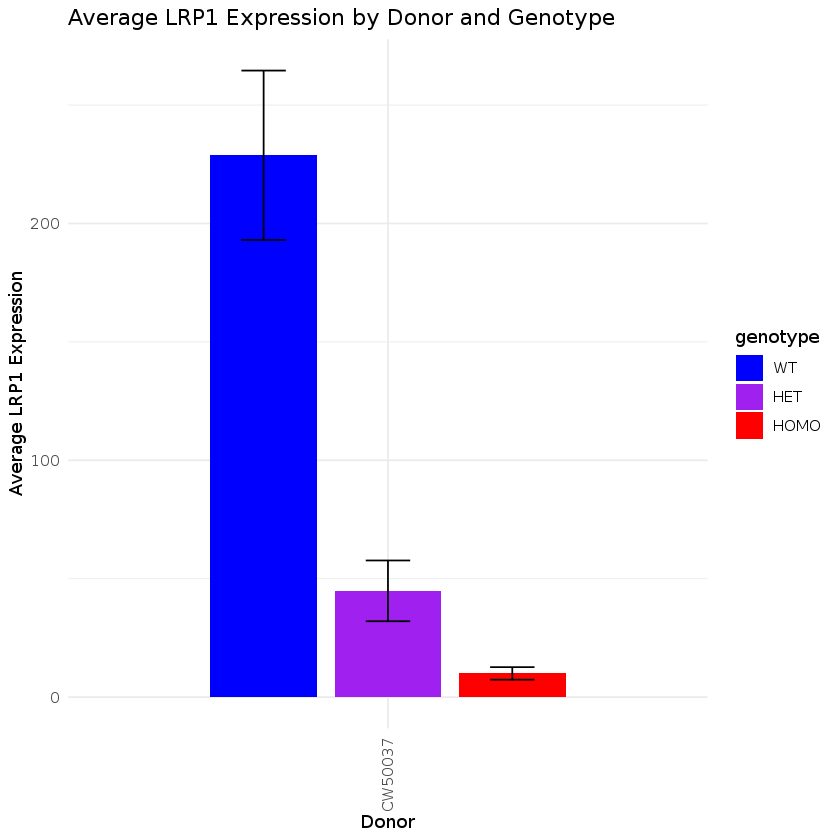

In [319]:
library(ggbeeswarm) 
summary_df <- plot_df %>%
  group_by(donor, genotype)# %>%
  #summarise(NRXN1_avg = mean(NRXN1, na.rm = TRUE), .groups = 'drop')


genotypes <- c("WT", "HET", "HOMO")  
all_combinations <- expand.grid(donor = unique(plot_df$donor), genotype = genotypes)

complete_df <- left_join(all_combinations, summary_df, by = c("donor", "genotype"))

complete_df <- complete_df %>%
  replace_na(list(NRXN1 = 0)) %>%
  mutate(genotype = factor(genotype, levels = genotypes))

genotype_colors <- c(WT = "blue", HET = "purple", HOMO = "red")

avg_df <- complete_df %>%
  group_by(donor, genotype) %>%
  summarise(
    NRXN1_avg = mean(NRXN1, na.rm = TRUE),
    NRXN1_sem = sd(NRXN1, na.rm = TRUE) / sqrt(n()),  
    .groups = 'drop'
  )

# plotting NRXN1 expression per genotype and donor
g_avg_bar <- ggplot(avg_df, aes(x = donor, y = NRXN1_avg, fill = genotype)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_errorbar(aes(ymin = NRXN1_avg - NRXN1_sem, ymax = NRXN1_avg + NRXN1_sem), 
                position = position_dodge(width = 0.7), width = 0.25) +
  scale_fill_manual(values = genotype_colors) +
  theme_minimal() +
  labs(title = "Average NRXN1 Expression by Donor and Genotype",
       x = "Donor",
       y = "Average NRXN1 Expression") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

g_avg_bar


In [321]:
full_plot_df <- merge(unique_donors_df, plot_df, by = "donor", all.x = TRUE)

# Create a new column combining donor and PRS levels
full_plot_df$donor_prs <- paste(full_plot_df$donor, "(", full_plot_df$PRS, ")", sep = "")


In [1]:
merged_df <- read.csv("/stanley/nehme_lab/sbolshak/analysis/village_editing/NRXN1/all_samples/all_samples_nrxn_dosage_merged_counts_no_sex_genes.csv")
head(merged_df)

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,CW20012_NRXN1_Het_a,CW50037_NRXN1_Homo_b,CW50037_NRXN1_Homo_c,...,CW20103_NRXN1_Homo_c,CW20103_NRXN1_Homo_d,ML9096344_NRXN1_WT_b,ML9096344_NRXN1_WT_c,ML9096344_NRXN1_WT_d,ML9119779_NRXN1_Homo_a,ML9119779_NRXN1_Homo_b,ML9119779_NRXN1_Homo_c,ML9119779_NRXN1_Homo_d,CW20103_NRXN1_Homo_a
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NRXN1,111.000773,-0.7392916,0.04906642,-15.067159,2.663222e-51,4.860113e-47,93.139782,53.306678,72.546110,...,95.863246,122.25789,234.144616,95.856617,191.229331,62.791584,87.603172,90.900703,54.633376,88.674205
2,CALD1,52.152135,0.6478427,0.11399529,5.683066,1.323016e-08,1.207185e-04,29.788843,23.099560,27.902350,...,29.011245,35.88003,18.011124,87.673735,28.046969,46.170283,34.279502,19.478722,29.417971,33.252827
3,COL1A1,63.893654,1.6616632,0.30316462,5.481059,4.227872e-08,2.571815e-04,8.142284,1.776889,1.116094,...,16.397660,71.76007,0.000000,15.196781,2.549724,14.774490,2.539222,0.000000,5.253209,20.936965
4,SPX,4.685142,1.3775105,0.25844526,5.329990,9.821838e-08,4.480968e-04,1.985923,7.996002,1.116094,...,1.261358,0.00000,0.000000,1.168983,2.549724,1.846811,1.269611,0.000000,0.000000,0.000000
5,TAGLN,46.106776,1.2833349,0.24694309,5.196885,2.026553e-07,7.396513e-04,3.376069,2.665334,4.464376,...,11.352226,22.59113,6.003708,264.190188,2.549724,11.080868,1.269611,6.492907,3.151926,7.389517
6,PLAU,5.428574,1.1722165,0.22729993,5.157135,2.507568e-07,7.626769e-04,2.383107,4.442223,4.464376,...,2.522717,0.00000,1.500927,2.337966,0.000000,0.000000,0.000000,0.000000,2.101284,0.000000


In [80]:
merged_df$gene <- toupper(merged_df$gene)
head(merged_df)

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ML8984425_LRP1_WT_a,ML8984425_LRP1_WT_b,ML8984425_LRP1_WT_c,...,CW50037_LRP1_Homo_e,CW50037_LRP1_Homo_f,CW50037_LRP1_Het_a,CW20102_LRP1_Het_a,CW20102_LRP1_Het_b,CW20102_LRP1_Het_c,CW50037_LRP1_WT_b,CW50037_LRP1_WT_c,CW50037_LRP1_WT_d,CW50037_LRP1_WT_a
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ogn,OGN,15.575193,-2.448080,0.4920952,-4.974809,6.531205e-07,0.009651161,110.44252,130,57.6980747,...,1.048964,1.024190,11,3,14,6,8.593539,23.276518,14,13.314464
Cxcl5,CXCL5,13.534048,-3.103512,0.6576375,-4.719184,2.367927e-06,0.017495428,154.87101,118,167.7682480,...,1.048964,4.096758,5,7,7,8,2.148385,7.084158,2,2.048379
Prelp,PRELP,25.232567,-2.337125,0.5141056,-4.546001,5.467469e-06,0.026930929,208.93965,155,169.5435734,...,6.293786,3.072569,9,6,42,12,15.038694,40.480900,41,24.580549
Crygs,CRYGS,3.543549,-2.458516,0.5661056,-4.342858,1.406412e-05,0.034637586,23.05252,26,21.3039045,...,1.048964,1.024190,1,1,1,1,1.074192,4.048090,4,2.048379
Pakap,PAKAP,9.683987,-2.744098,0.6310203,-4.348669,1.369665e-05,0.034637586,56.16432,34,0.8876627,...,1.048964,1.024190,74,1,28,65,17.187078,10.120225,43,14.338654
Wfdc2,WFDC2,3.985960,-2.346025,0.5296863,-4.429084,9.463428e-06,0.034637586,50.71554,13,27.5175433,...,1.048964,1.024190,1,1,1,1,1.074192,9.108203,14,2.048379


In [81]:
library(fgsea)
library(forcats)

run_gsea_analysis <- function(donor_name, merged_results, gmt_paths) {
  
  # Function to create ranked log2 fold change vector
  make_ranked_log2fc <- function(merged_results) {
    rnk_vec <- deframe(merged_results[c("gene", "log2FoldChange")])
    rnk_vec <- rnk_vec[order(-rnk_vec)]
    return(rnk_vec)
  }
  
  ranked_logfc <- make_ranked_log2fc(merged_results)
  ranked_logfc_clean <- ranked_logfc[!is.na(ranked_logfc)]
  
  # Function to run FGSEA
  run_fgsea <- function(gmt_file_path, rnk_list, min_size, max_size) {
    fgsea_file <- fgsea::gmtPathways(gmt_file_path)
    fgsea_res <- fgsea(fgsea_file, rnk_list, minSize = min_size, maxSize = max_size)
    fgsea_res <- as_tibble(fgsea_res)
    return(fgsea_res)
  }
  
  # Initialize an empty list to store results
  fgsea_results <- list()
  
  # Iterate over the GMT file paths
  for (gmt_path in gmt_paths) {
    fgsea_res <- run_fgsea(gmt_path, ranked_logfc_clean, 15, 500)
    fgsea_results[[gmt_path]] <- fgsea_res
  }
  
  # Process and save results for each GMT file
  for (gmt_path in names(fgsea_results)) {
    fgsea_res_filt <- filter(fgsea_results[[gmt_path]], padj <= 0.05)
    
    # Create a data frame for the filtered results
    fgsea_res_df <- as.data.frame(fgsea_res_filt)
    list_cols <- sapply(fgsea_res_df, is.list)
    
    # Transform list columns
    fgsea_res_df[list_cols] <- lapply(fgsea_res_df[list_cols], function(x) {
      sapply(x, function(l) paste(l, collapse=", "))  
    })
    
    # Save the results
    gmt_name <- sub("^.*?/data/(.*)\\.gmt$", "\\1", gmt_path)
    output_file <- paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/GSEA/NRXN1/", donor_name, "_lrp1_mouse_final_", gmt_name, ".tsv")
    write_tsv(fgsea_res_df, output_file)
    
    # Create plots
    top_pathways <- function(fgsea_results, num_paths, padj_threshold) {
      fgsea_results <- fgsea_results %>%
        filter(padj <= padj_threshold) %>%
        mutate(negLogPadj = -log10(padj))
      
      fgsea_top <- fgsea_results %>%
        arrange(desc(abs(NES))) %>%
        slice_head(n = num_paths)
      
      p <- ggplot(fgsea_top, aes(x = NES, y = reorder(pathway, order(NES, decreasing = FALSE)))) +
        geom_point(aes(color = -log10(padj), size = size)) +
        labs(title = paste(donor_name, "GSEA results:", gmt_name),
             y = "Pathway", x = "NES") +
        theme_minimal()
      
      return(p)
    }
    
    plot <- top_pathways(fgsea_res_filt, 30, 0.05)
    ggsave(filename = paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/GSEA/NRXN1/", donor_name, "_lrp1_mouse_final_", gmt_name, ".png"), plot = plot, width = 12, height = 6, bg = "white")
  }
}

donor_name <- "all_samples"
gmt_files <- c('/stanley/nehme_lab/sbolshak/analysis/village_editing/data/h.all.v2024.1.Hs.symbols.gmt',
               '/stanley/nehme_lab/sbolshak/analysis/village_editing/data/c2.cp.v2024.1.Hs.symbols.gmt',
               '/stanley/nehme_lab/sbolshak/analysis/village_editing/data/c5.go.v7.4.syngo.bp.cc.v1.1.symbols.humgenSCZ.SCHEMA1.and.GWAS.1-2.gmt')

run_gsea_analysis(donor_name, merged_df, gmt_files)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (29.54% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (29.54% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and

## PEER

In [ ]:
?

## WGCNA ##

# Run TRADE

In [76]:
#counts <- read.table("/stanley/nehme_lab/sbolshak/analysis/village_editing/NRXN1/nrxn1_human_counts_final_filtered_no_sex_genes.csv", sep = ',', header = TRUE)
counts <- read.table("/stanley/nehme_lab/sbolshak/analysis/village_editing/NRXN1/all_samples/nrxn1_dge_raw_counts_no_awful_rna_more_than_2.txt", sep = '\t', header = TRUE)
counts[is.na(counts)] <- 0
rownames(counts) <- counts$GENE
counts <- counts[-1]
colnames(counts) <- gsub("\\.", "", colnames(counts))
#counts <- counts[, grepl("ML910-8360|ML911.9779|ML907-2836|ML898-4425|ML611-3363", colnames(counts))] #dosage

#donor_name = "dosage_only"
head(counts)

,CW20012_NRXN1_Het_a,CW50037_NRXN1_Homo_b,CW50037_NRXN1_Homo_c,CW50037_NRXN1_Homo_d,CW20012_NRXN1_Het_b,CW20012_NRXN1_Het_c,CW20012_NRXN1_Het_d,ML8984425_NRXN1_Homo_a,ML8984425_NRXN1_Homo_b,ML8984425_NRXN1_Homo_c,...,ML9096344_NRXN1_WT_d,ML9119779_NRXN1_Homo_a,ML9119779_NRXN1_Homo_b,ML9119779_NRXN1_Homo_c,ML9119779_NRXN1_Homo_d,CW20103_NRXN1_Homo_a,CW20012_NRXN1_Homo_a,CW20012_NRXN1_Homo_b,CW20012_NRXN1_Homo_c,CW20012_NRXN1_Homo_d
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5_8S_rRNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,86,14,22,13,38,26,28,25,4,33,...,1,11,9,0,14,13,34,19,28,26
A1BG-AS1,69,21,12,13,10,12,7,8,2,4,...,1,2,1,3,7,1,18,10,24,24
A1CF,4,1,1,2,1,0,0,0,1,0,...,1,1,1,0,0,0,0,0,4,0
A2M,2602,507,345,300,1417,1547,1415,498,1,278,...,25,94,282,84,676,276,1913,1350,1420,2105


In [77]:
gene_list_cholest <- c("CLU", "SOAT1", "HMGCR", "LRP1", "APOE", "APOD", "LDLR", 
"NR1H3", "NR1H2", "SREBF2", "SREBF1", "ABCA1", "ABCG1", "FABP3", "FABP5", "FABP7")

In [78]:
counts<- counts[rownames(counts) %in% gene_list_cholest, ]
counts

,CW20012_NRXN1_Het_a,CW50037_NRXN1_Homo_b,CW50037_NRXN1_Homo_c,CW50037_NRXN1_Homo_d,CW20012_NRXN1_Het_b,CW20012_NRXN1_Het_c,CW20012_NRXN1_Het_d,ML8984425_NRXN1_Homo_a,ML8984425_NRXN1_Homo_b,ML8984425_NRXN1_Homo_c,...,ML9096344_NRXN1_WT_d,ML9119779_NRXN1_Homo_a,ML9119779_NRXN1_Homo_b,ML9119779_NRXN1_Homo_c,ML9119779_NRXN1_Homo_d,CW20103_NRXN1_Homo_a,CW20012_NRXN1_Homo_a,CW20012_NRXN1_Homo_b,CW20012_NRXN1_Homo_c,CW20012_NRXN1_Homo_d
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABCA1,654,119,120,102,357,293,287,1330,1,1236,...,285,368,624,32,179,402,1087,2034,754,872
ABCG1,13,4,5,3,5,2,9,1,0,3,...,4,2,3,5,1,1,14,7,9,8
APOD,3,0,3,0,3,0,3,0,1,3,...,0,1,2,0,3,0,2,4,1,0
APOE,4,2,0,0,0,4,3,2,0,0,...,0,2,0,0,0,0,2,4,3,3
CLU,2006,599,436,478,423,296,314,43,1,30,...,26,33,57,12,75,80,565,277,430,475
FABP3,64,8,14,27,22,21,6,42,1,25,...,8,38,24,3,49,20,54,36,44,67
FABP5,944,191,187,216,501,361,332,165,28,126,...,69,73,74,20,84,83,277,170,213,225
FABP7,1,0,1,0,3,4,1,8,0,8,...,2,2,4,2,1,0,2,3,1,0
HMGCR,2743,741,461,335,1161,1301,1337,358,3,249,...,220,232,463,136,948,389,3333,2052,2186,3144


In [79]:
#metadata <- 
metadata

sample,gene,donor,genotype,target_gt,PRS,sex,plate,group
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CW20012_NRXN1_Het_a,NRXN1,CW20012,HET,NRXN1_HET,HIGH,Female,a,CW20012.NRXN1_HET
CW50037_NRXN1_Homo_b,NRXN1,CW50037,HOMO,NRXN1_HOMO,NEUTRAL,Female,a,CW50037.NRXN1_HOMO
CW50037_NRXN1_Homo_c,NRXN1,CW50037,HOMO,NRXN1_HOMO,NEUTRAL,Female,a,CW50037.NRXN1_HOMO
CW50037_NRXN1_Homo_d,NRXN1,CW50037,HOMO,NRXN1_HOMO,NEUTRAL,Female,a,CW50037.NRXN1_HOMO
CW20012_NRXN1_Het_b,NRXN1,CW20012,HET,NRXN1_HET,HIGH,Female,a,CW20012.NRXN1_HET
CW20012_NRXN1_Het_c,NRXN1,CW20012,HET,NRXN1_HET,HIGH,Female,a,CW20012.NRXN1_HET
CW20012_NRXN1_Het_d,NRXN1,CW20012,HET,NRXN1_HET,HIGH,Female,a,CW20012.NRXN1_HET
ML8984425_NRXN1_Homo_a,NRXN1,ML8984425,HOMO,NRXN1_HOMO,LOW,Female,b,ML8984425.NRXN1_HOMO
ML8984425_NRXN1_Homo_b,NRXN1,ML8984425,HOMO,NRXN1_HOMO,LOW,Female,b,ML8984425.NRXN1_HOMO


In [80]:
# first run differential expression on data using DEseq2
library(DESeq2,verbose=F)

# create metadata dataframe containing sgRNA conditions/target conditions
coldata <- data.frame(row.names=colnames(counts))
coldata$target_gt <- as.factor(metadata[match(rownames(coldata),metadata$sample),"target_gt"])
# coldata$plate <- as.factor(metadata[match(rownames(coldata),metadata$sample),"plate"])
coldata$PRS <- as.factor(metadata[match(rownames(coldata),metadata$sample),"PRS"])
coldata$donor <- as.factor(metadata[match(rownames(coldata),metadata$sample),"donor"])
coldata$group <- paste0(coldata$donor,".",coldata$target_gt)

#metadata$genotype_dosage <- as.numeric(factor(metadata$target_gt, levels=c("NRXN1_WT", "NRXN1_HET", "NRXN1_HOMO"))) - 1

# Create a DESeqDataSet
#dds <- DESeqDataSetFromMatrix(countData = counts, colData = metadata, design = ~ genotype_dosage)
# create DESeq2 dataset, using sgRNA as design matrix
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = coldata,
                              design = ~0 + group)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


In [81]:
# filter dataset to only use genes with >10 counts in >=3 samples
smallestGroupSize <- 3
keep <- rowSums(counts(dds) >= 50) >= smallestGroupSize
table(keep)
dds <- dds[keep,]

keep
FALSE  TRUE 
    5    11 

In [88]:
dds <- DESeq(dds) #,test="LRT",reduced=~plate,useT=TRUE,minmu=1e-6,minReplicatesForReplace=Inf)
#res <- results(dds,contrast=c("target_gt","NRXN1_HOMO","NRXN1_WT"))
res

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GENE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
319.29957,-0.93293228,0.7687211,-1.2136161,0.22489437,0.4947676,ABCA1
173.07499,-0.20765563,0.3635182,-0.5712386,0.56783792,0.7807771,CLU
25.21117,-0.90394874,0.5525660,-1.6359110,0.10185822,0.4947676,FABP3
163.19709,0.04622431,0.3891617,0.1187792,0.90545031,0.9054503,FABP5
14.93114,-1.70367313,1.5913761,-1.0705660,0.28436461,0.5213351,FABP7
645.11077,0.60613537,0.2926384,2.0712776,0.03833286,0.4216615,HMGCR
82.97981,0.21984599,0.3552826,0.6187918,0.53605352,0.7807771,LDLR
120.07180,0.79356096,0.5425479,1.4626561,0.14356151,0.4947676,LRP1
15.38151,-0.54100953,0.4268102,-1.2675646,0.20495346,0.4947676,NR1H2


In [83]:
resultsNames(dds)

[1] "groupCW20012.NRXN1_HET"    "groupCW20012.NRXN1_HOMO"  
 [3] "groupCW20012.NRXN1_WT"     "groupCW20103.NRXN1_HOMO"  
 [5] "groupCW20103.NRXN1_WT"     "groupCW30154.NRXN1_HOMO"  
 [7] "groupCW30154.NRXN1_WT"     "groupCW50037.NRXN1_HOMO"  
 [9] "groupCW50037.NRXN1_WT"     "groupML6112911.NRXN1_HOMO"
[11] "groupML6112911.NRXN1_WT"   "groupML6113363.NRXN1_HET" 
[13] "groupML6113363.NRXN1_HOMO" "groupML6113363.NRXN1_WT"  
[15] "groupML8326778.NRXN1_HOMO" "groupML8984425.NRXN1_HET" 
[17] "groupML8984425.NRXN1_HOMO" "groupML8984425.NRXN1_WT"  
[19] "groupML9072836.NRXN1_HET"  "groupML9072836.NRXN1_HOMO"
[21] "groupML9072836.NRXN1_WT"   "groupML9096344.NRXN1_HOMO"
[23] "groupML9096344.NRXN1_WT"   "groupML9108360.NRXN1_HET" 
[25] "groupML9108360.NRXN1_HOMO" "groupML9108360.NRXN1_WT"  
[27] "groupML9119779.NRXN1_HET"  "groupML9119779.NRXN1_HOMO"
[29] "groupML9119779.NRXN1_WT"

In [ ]:
#old
library(data.table)
dir.create("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/NRXN1/")
targets_list <- unique(coldata[! coldata$target_gt %in% c("NRXN1_WT","LRP1_WT"),"group"])
for (target in targets_list) {
    if (grepl("NRXN1", target) & !grepl("WT", target)) {
    donor <- sub("\\..*", "", target)
    if (! paste0("group",donor,".NRXN1_WT") %in% resultsNames(dds)) { 
        next 
    } else {
        print(target)
        res_tmp <- results(dds,contrast=c("group",target,paste0(donor,".NRXN1_WT")))
    }
} else if (grepl("LRP1", target) & !grepl("WT", target)) {
    donor <- sub("\\..*", "", target)
    if (! paste0("group",donor,".LRP1_WT") %in% resultsNames(dds)) { 
        next 
    } else {
        print(target)
        res_tmp <- results(dds,contrast=c("group",target,paste0(donor,".LRP1_WT")))
    }
    } else {
        if (! paste0("group",donor,".NRXN1_WT") %in% resultsNames(dds)) { 
    message("Skipping: contrast group",donor,".NRXN1_WT not found")
    next 
}
        next
    }
    res_tmp_df <- as.data.frame(res_tmp)
    res_tmp_df$GENE <- rownames(res_tmp_df)
    # break
    write.table(as.data.frame(res_tmp_df),paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/NRXN1/",target,"_vs_CTRL.results.txt"),sep="\t",quote=F,row.names=F,col.names=T)
}
print("Done!")

In [60]:
dir.create("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/dosage/", recursive = TRUE)

targets_list <- unique(coldata[! coldata$target_gt %in% c("NRXN1_WT", "LRP1_WT"), "group"])

for (target in targets_list) {
    # Parse donor ID from group name (everything before the last period)
    donor <- gsub("-", ".", sub("\\.([^.]+)$", "", target))

    if (grepl("NRXN1", target) & !grepl("WT", target)) {
        ref_group <- paste0("group", donor, ".NRXN1_WT")
        if (! ref_group %in% resultsNames(dds)) {
            message("Skipping: contrast ", ref_group, " not found")
            next
        }
        print(paste("Running:", target))
        res_tmp <- results(dds, contrast = c("group", target, paste0(donor, ".NRXN1_WT")))

    } else if (grepl("LRP1", target) & !grepl("WT", target)) {
        ref_group <- paste0("group", donor, ".LRP1_WT")
        if (! ref_group %in% resultsNames(dds)) {
            message("Skipping: contrast ", ref_group, " not found")
            next
        }
        print(paste("Running:", target))
        res_tmp <- results(dds, contrast = c("group", target, paste0(donor, ".LRP1_WT")))

    } else {
        next
    }

    res_tmp_df <- as.data.frame(res_tmp)
    res_tmp_df$GENE <- rownames(res_tmp_df)

    out_path <- paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/dosage/", target, "_vs_CTRL.results.txt")
    write.table(res_tmp_df, out_path, sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE)
}
print("Done!")

Warning message in dir.create("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/dosage/", :
"'/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/dosage' already exists"


[1] "Running: ML898-4425.NRXN1_HOMO"
[1] "Running: ML611-3363.NRXN1_HOMO"
[1] "Running: ML910-8360.NRXN1_HET"
[1] "Running: ML611-3363.NRXN1_HET"
[1] "Running: ML910-8360.NRXN1_HOMO"
[1] "Running: ML907-2836.NRXN1_HOMO"
[1] "Running: ML898-4425.NRXN1_HET"
[1] "Running: ML907-2836.NRXN1_HET"
[1] "Running: ML911-9779.NRXN1_HET"
[1] "Running: ML911-9779.NRXN1_HOMO"
[1] "Done!"


In [ ]:
targets_list

In [91]:
library(mashr)
library(ggplot2)
library(ashr)
library(TRADE)
targets_list <- unique(coldata[! coldata$target_gt %in% c("NRXN1_WT","LRP1_WT"),"group"])
deseq_res_files <- list.files("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/NRXN1/")
# run TRADE on ecah set of differential expression results, then write the combined results to a new summary file
TRADE_out_df <- data.frame(row.names=c("mean","transcriptome_wide_impact","Me","KD"))
for (target in targets_list) {
    print(target)
    if (target %like% "NRXN1" & !target %like% "WT") {
        print("NRXN1...")
        donor <- sub("\\..*", "", target)
        if (! paste0(target,"_vs_CTRL.results.txt") %in% deseq_res_files) { 
            next 
        } else {
            print(target)
            res <- read.table(paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/NRXN1/",target,"_vs_CTRL.results.txt"),sep="\t",header=T)
            TRADE_tmp <- TRADE(mode="univariate",results1=res)
            TRADE_out_df[c("mean","transcriptome_wide_impact","Me"),target] <- as.numeric(TRADE_tmp$distribution_summary)
            TRADE_out_df["KD",target] <- ifelse(res[res$GENE=="NRXN1",'padj']<0.05,TRUE,FALSE)
        }
    } else if (target %like% "LRP1" & !target %like% "WT") {
        print("LRP1...")
        donor <- sub("\\..*", "", target)
        if (! paste0(target,"_vs_CTRL.results.txt") %in% deseq_res_files){ 
            next 
        } else {
            res <- read.table(paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/NRXN1/",target,"_vs_CTRL.results.txt"),sep="\t",header=T)
            TRADE_tmp <- TRADE(mode="univariate",results1=res)
            TRADE_out_df[c("mean","transcriptome_wide_impact","Me"),target] <- as.numeric(TRADE_tmp$distribution_summary)
            TRADE_out_df["KD",target] <- ifelse(res[res$GENE=="LRP1",'padj']<0.05,TRUE,FALSE)
        }
    } else {
        next
    }
    print(target)

    # res <- read.table(paste0("/broad/mccarroll/npettina/analysis/village_editing/DESeq2/by_donor/",target,"_vs_CTRL.results.txt"),sep="\t",header=T)
    # TRADE_tmp <- TRADE(mode="univariate",results1=res)
    # TRADE_out_df[,target] <- as.numeric(TRADE_tmp$distribution_summary)
}

TRADE_out_df <- as.data.frame(t(TRADE_out_df))
TRADE_out_df$target <- rownames(TRADE_out_df)
TRADE_out_df


[1] "CW20012.NRXN1_HET"
[1] "NRXN1..."
[1] "CW20012.NRXN1_HET"


0 genes excluded with NA entries

0 genes excluded with extreme log2FC (abs value > 10)

11 genes retained for analysis

Fitting mixture model

Warning message in check_args(mixcompdist, df, prior, optmethod, gridmult, sebetahat, :
"Use of halfuniform without nullbiased prior can lead to misleading local false sign rates, and so is not recommended"


ERROR: Error in x[[jj]][iseq] <- vjj: replacement has length zero


In [75]:
#PRS
library(mashr)
library(ggplot2)
library(ashr)
library(TRADE)

# Assuming PRS values are in coldata$group
targets_list <- unique(coldata[! coldata$target_gt %in% c("PRSLOW"), "group"])

# Load DESeq2 result files
deseq_res_files <- list.files("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/dosage/")

# Prepare an empty dataframe for TRADE output
TRADE_out_df <- data.frame(row.names=c("mean", "transcriptome_wide_impact", "Me", "KD"))

for (target in targets_list) {
    print(target)
    
    if (grepl("PRS", target) & !grepl("LOW", target)) {  # Adjusted for PRS condition
        print("Processing PRS target...")
        
        # Ensure the corresponding results file exists
        if (!paste0(target, "_vs_CTRL.results.txt") %in% deseq_res_files) { 
            next 
        } else {
            res <- read.table(paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/dosage/", target, "_vs_CTRL.results.txt"), sep="\t", header=T)
            TRADE_tmp <- TRADE(mode="univariate", results1=res)
            
            # Extract summary results from TRADE output and store in the output dataframe
            TRADE_out_df[c("mean", "transcriptome_wide_impact", "Me"), target] <- as.numeric(TRADE_tmp$distribution_summary)
            
            # Check if the contrast for the target is significant based on the p-value (adjusted)
            TRADE_out_df["KD", target] <- ifelse(res[res$GENE == target, 'padj'] < 0.05, TRUE, FALSE)
        }
    } else {
        next  # Skip if not a valid PRS target
    }

    print(target)
}

# Transpose the dataframe so that each target is a row
TRADE_out_df <- as.data.frame(t(TRADE_out_df))

# Add the target column to the output dataframe
TRADE_out_df$target <- rownames(TRADE_out_df)

# View the final TRADE output
TRADE_out_df

Loading required package: ashr



[1] "ML9108360.NRXN1_WT"
[1] "CW20012.NRXN1_WT"
[1] "ML8984425.NRXN1_WT"
[1] "ML9072836.NRXN1_WT"
[1] "ML9119779.NRXN1_WT"
[1] "CW20103.NRXN1_WT"
[1] "CW30154.NRXN1_WT"
[1] "ML6112911.NRXN1_WT"
[1] "ML6113363.NRXN1_WT"
[1] "CW50037.NRXN1_WT"
[1] "ML9096344.NRXN1_WT"


mean,transcriptome_wide_impact,Me,KD,target
<lgl>,<lgl>,<lgl>,<lgl>,<chr>


In [76]:
targets_list <- unique(coldata[! coldata$target_gt %in% c("NRXN1_WT","LRP1_WT"),"group"])
deseq_res_files <- list.files("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/NRXN1/") 
deseq_res_files

[1] "ML611-3363.NRXN1_HET_vs_CTRL.results.txt" 
 [2] "ML611-3363.NRXN1_HOMO_vs_CTRL.results.txt"
 [3] "ML898-4425.NRXN1_HET_vs_CTRL.results.txt" 
 [4] "ML898-4425.NRXN1_HOMO_vs_CTRL.results.txt"
 [5] "ML907-2836.NRXN1_HET_vs_CTRL.results.txt" 
 [6] "ML907-2836.NRXN1_HOMO_vs_CTRL.results.txt"
 [7] "ML910-8360.NRXN1_HET_vs_CTRL.results.txt" 
 [8] "ML910-8360.NRXN1_HOMO_vs_CTRL.results.txt"
 [9] "ML911-9779.NRXN1_HET_vs_CTRL.results.txt" 
[10] "ML911-9779.NRXN1_HOMO_vs_CTRL.results.txt"
[11] "NRXN1.trade_dist_summary.csv"             
[12] "NRXN1_LRP1.trade_dist_summary.txt"

In [69]:
write.table(TRADE_out_df,paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/NRXN1/NRXN1_all_samps.trade_dist_summary.txt"),sep="\t",col.names=T,row.names=T,quote=F)

In [67]:
TRADE_out_df <- read.table("/stanley/nehme_lab/sbolshak/analysis/village_editing/TRADE/NRXN1/NRXN1_all_samps.trade_dist_summary.txt", row.names = 1,  header =TRUE)
TRADE_out_df 

ERROR: Error in data[[rlabp]]: attempt to select less than one element in get1index <real>


In [70]:
TRADE_out_df$donor <- sub("\\..*", "", TRADE_out_df$target)
TRADE_out_df

,mean,transcriptome_wide_impact,Me,KD,target,donor
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CW20012.NRXN1_HET,2.439318e-02,0.176190923,891.54625,0,CW20012.NRXN1_HET,CW20012
CW50037.NRXN1_HOMO,-2.082726e-02,0.157178724,625.71216,1,CW50037.NRXN1_HOMO,CW50037
ML8984425.NRXN1_HOMO,2.325386e-02,0.164466419,430.25435,1,ML8984425.NRXN1_HOMO,ML8984425
ML6113363.NRXN1_HOMO,-3.483774e-02,0.142866882,4227.74807,1,ML6113363.NRXN1_HOMO,ML6113363
ML9108360.NRXN1_HET,-2.632428e-02,0.033663774,192.74488,0,ML9108360.NRXN1_HET,ML9108360
ML6113363.NRXN1_HET,-2.638590e-02,0.081901277,2891.83326,1,ML6113363.NRXN1_HET,ML6113363
ML9096344.NRXN1_HOMO,-1.099074e-01,0.256551033,527.82807,1,ML9096344.NRXN1_HOMO,ML9096344
ML9108360.NRXN1_HOMO,-1.203658e-03,0.074144684,103.13340,1,ML9108360.NRXN1_HOMO,ML9108360
ML9072836.NRXN1_HOMO,1.275562e-01,0.972080303,1420.01647,1,ML9072836.NRXN1_HOMO,ML9072836


In [71]:
metadata_distinct <- metadata[!duplicated(metadata$donor), c("donor", "PRS", "sex", "genotype")]

# Merge with TRADE_out_df
TRADE_out_df <- merge(TRADE_out_df, metadata_distinct, by = "donor", all.x = TRUE)
TRADE_out_df <- TRADE_out_df %>%
  select(-ends_with(".y"))
TRADE_out_df

donor,mean,transcriptome_wide_impact,Me,KD,target,PRS,sex,genotype
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
CW20012,2.439318e-02,0.176190923,891.54625,0,CW20012.NRXN1_HET,HIGH,Female,HET
CW20012,5.225989e-02,0.399773576,2603.55455,1,CW20012.NRXN1_HOMO,HIGH,Female,HET
CW20103,1.932021e-03,0.035331934,1039.64447,1,CW20103.NRXN1_HOMO,NEUTRAL,Female,WT
CW30154,5.636151e-03,0.009991955,15.01811,1,CW30154.NRXN1_HOMO,LOW,Female,WT
CW50037,-2.082726e-02,0.157178724,625.71216,1,CW50037.NRXN1_HOMO,NEUTRAL,Female,HOMO
ML6112911,-1.655842e-06,0.111548011,5906.62505,0,ML6112911.NRXN1_HOMO,NEUTRAL,Male,HOMO
ML6113363,-3.483774e-02,0.142866882,4227.74807,1,ML6113363.NRXN1_HOMO,HIGH,Male,HOMO
ML6113363,-2.638590e-02,0.081901277,2891.83326,1,ML6113363.NRXN1_HET,HIGH,Male,HOMO
ML8984425,2.325386e-02,0.164466419,430.25435,1,ML8984425.NRXN1_HOMO,LOW,Female,HOMO


In [72]:
TRADE_out_df[TRADE_out_df$KD==1,]

,donor,mean,transcriptome_wide_impact,Me,KD,target,PRS,sex,genotype
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
2,CW20012,0.052259888,0.399773576,2603.55455,1,CW20012.NRXN1_HOMO,HIGH,Female,HET
3,CW20103,0.001932021,0.035331934,1039.64447,1,CW20103.NRXN1_HOMO,NEUTRAL,Female,WT
4,CW30154,0.005636151,0.009991955,15.01811,1,CW30154.NRXN1_HOMO,LOW,Female,WT
5,CW50037,-0.020827258,0.157178724,625.71216,1,CW50037.NRXN1_HOMO,NEUTRAL,Female,HOMO
7,ML6113363,-0.034837737,0.142866882,4227.74807,1,ML6113363.NRXN1_HOMO,HIGH,Male,HOMO
8,ML6113363,-0.026385896,0.081901277,2891.83326,1,ML6113363.NRXN1_HET,HIGH,Male,HOMO
9,ML8984425,0.023253859,0.164466419,430.25435,1,ML8984425.NRXN1_HOMO,LOW,Female,HOMO
10,ML8984425,-0.008778141,0.018178681,37.70816,1,ML8984425.NRXN1_HET,LOW,Female,HOMO
11,ML9072836,0.022670958,0.373790896,1612.32504,1,ML9072836.NRXN1_HET,NEUTRAL,Female,HOMO


In [ ]:
target <- "ML9072836.NRXN1_HOMO"
trade_res <- read.table(paste0("/stanley/nehme_lab/sbolshak/analysis/village_editing/DESeq2/by_donor/",target,"_vs_CTRL.results.txt"),sep="\t",header=T)

In [73]:
trade_res[order(trade_res$padj),]
trade_res[trade_res$GENE=="NRXN1",]

ERROR: Error in eval(expr, envir, enclos): object 'trade_res' not found


In [ ]:
as.character(ifelse(results[results$ID=='NRXN1',paste0("P.value.adj.",TRADE_out_df$target)]<0.05,'PASS','FAIL'))

[1] "FAIL" "PASS" "FAIL" "PASS" "PASS" "PASS" "PASS" "PASS" "PASS" "FAIL"
[11] "PASS" "PASS"

,donor,mean,transcriptome_wide_impact,Me,KD,target,PRS,sex,genotype
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,CW20012,2.439318e-02,0.176190923,891.54625,0,CW20012.NRXN1_HET,HIGH,Female,HET
2,CW20012,5.225989e-02,0.399773576,2603.55455,1,CW20012.NRXN1_HOMO,HIGH,Female,HET
3,CW20103,1.932021e-03,0.035331934,1039.64447,1,CW20103.NRXN1_HOMO,NEUTRAL,Female,WT
4,CW30154,5.636151e-03,0.009991955,15.01811,1,CW30154.NRXN1_HOMO,LOW,Female,WT
5,CW50037,-2.082726e-02,0.157178724,625.71216,1,CW50037.NRXN1_HOMO,NEUTRAL,Female,HOMO
6,ML6112911,-1.655842e-06,0.111548011,5906.62505,0,ML6112911.NRXN1_HOMO,NEUTRAL,Male,HOMO


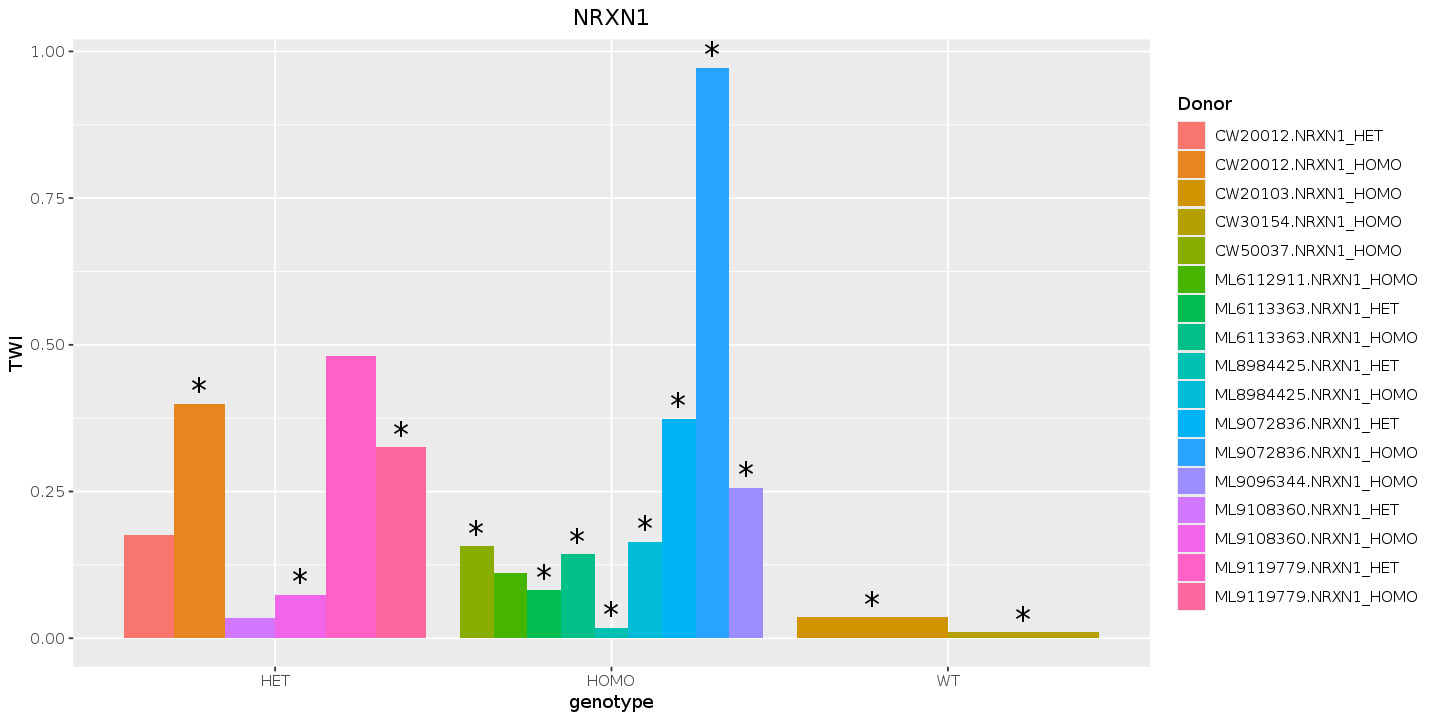

In [73]:
# TRADE_out_df <- read.table("/broad/mccarroll/npettina/analysis/village_editing/DESeq2/by_donor/NRXN1_LRP1.trade_dist_summary.txt",sep="\t",header=T)
# TRADE_out_df <- TRADE_out_df[TRADE_out_df$target %like% "NRXN1",]
metadata$group <- paste0(metadata$donor,".",metadata$target_gt)
TRADE_out_df$PRS <- metadata[match(TRADE_out_df$target,metadata$group),"PRS"]
# TRADE_out_df$KO_pass <- as.logical(ifelse(results[results$ID=='NRXN1',paste0("P.value.adj.",TRADE_out_df$target)]<0.05,TRUE,FALSE))
head(TRADE_out_df)
# TRADE_homo <- TRADE_out_df[TRADE_out_df$target %like% "NRXN1_HOMO",]
# TRADE_homo$PRS <- factor(TRADE_homo$PRS,levels=c("NONE","LOW","NEUTRAL","HIGH"))
options(repr.plot.width=12,repr.plot.height=6)
ggplot(TRADE_out_df,aes(x=genotype,y=transcriptome_wide_impact)) +
    geom_bar(aes(fill=target),position="dodge",stat="identity") +
    labs(y="TWI",fill="Donor",title="NRXN1") +
    theme(plot.title = element_text(hjust=0.5)) +
    geom_text(aes(label = ifelse(KD, "*", ""), group = target),position = position_dodge(width = 0.9), vjust = -.1, size = 20 / .pt)

,donor,mean,transcriptome_wide_impact,Me,KD,target,PRS,sex,genotype
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,CW20012,2.439318e-02,0.176190923,891.54625,0,CW20012.NRXN1_HET,HIGH,Female,HET
2,CW20012,5.225989e-02,0.399773576,2603.55455,1,CW20012.NRXN1_HOMO,HIGH,Female,HET
3,CW20103,1.932021e-03,0.035331934,1039.64447,1,CW20103.NRXN1_HOMO,NEUTRAL,Female,WT
4,CW30154,5.636151e-03,0.009991955,15.01811,1,CW30154.NRXN1_HOMO,LOW,Female,WT
5,CW50037,-2.082726e-02,0.157178724,625.71216,1,CW50037.NRXN1_HOMO,NEUTRAL,Female,HOMO
6,ML6112911,-1.655842e-06,0.111548011,5906.62505,0,ML6112911.NRXN1_HOMO,NEUTRAL,Male,HOMO


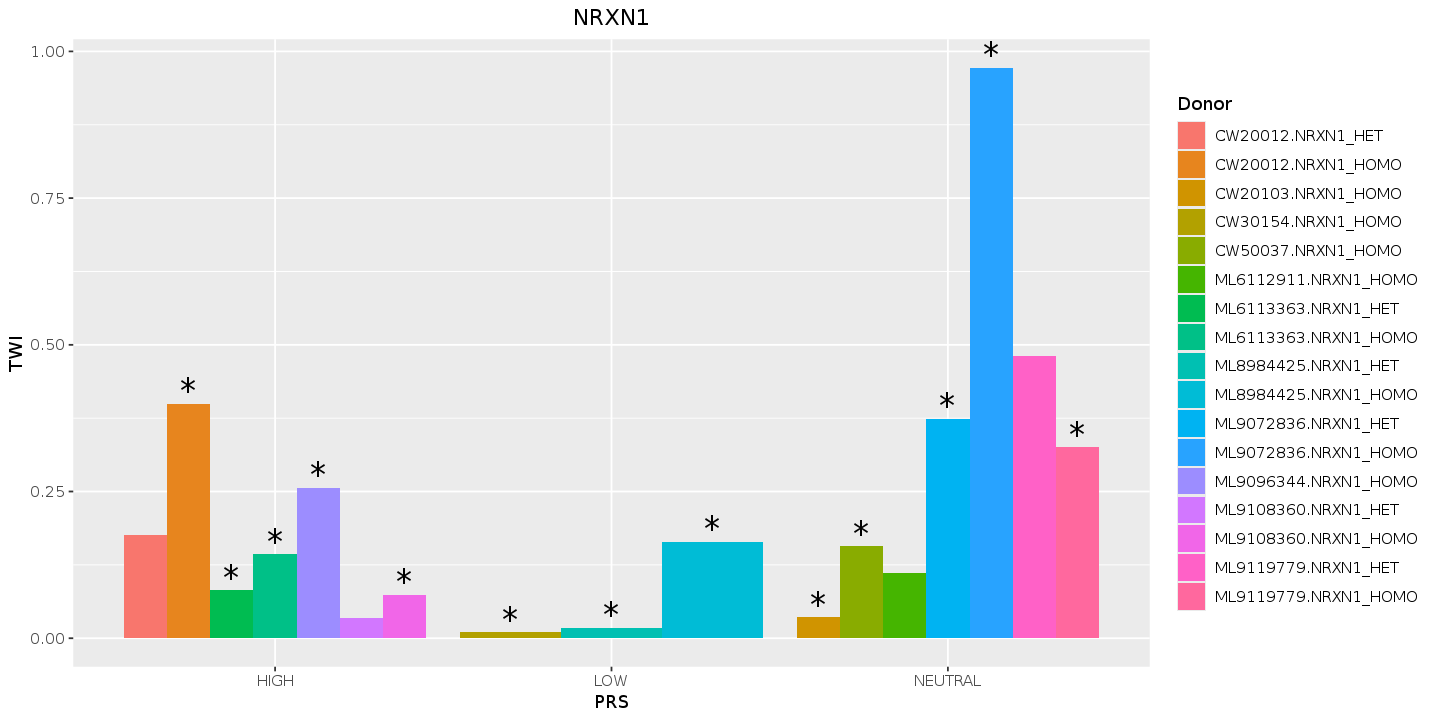

In [75]:
# TRADE_out_df <- read.table("/broad/mccarroll/npettina/analysis/village_editing/DESeq2/by_donor/NRXN1_LRP1.trade_dist_summary.txt",sep="\t",header=T)
# TRADE_out_df <- TRADE_out_df[TRADE_out_df$target %like% "NRXN1",]
metadata$group <- paste0(metadata$donor,".",metadata$target_gt)
TRADE_out_df$PRS <- metadata[match(TRADE_out_df$target,metadata$group),"PRS"]
# TRADE_out_df$KO_pass <- as.logical(ifelse(results[results$ID=='NRXN1',paste0("P.value.adj.",TRADE_out_df$target)]<0.05,TRUE,FALSE))
head(TRADE_out_df)
# TRADE_homo <- TRADE_out_df[TRADE_out_df$target %like% "NRXN1_HOMO",]
# TRADE_homo$PRS <- factor(TRADE_homo$PRS,levels=c("NONE","LOW","NEUTRAL","HIGH"))
options(repr.plot.width=12,repr.plot.height=6)
ggplot(TRADE_out_df,aes(x=PRS,y=transcriptome_wide_impact)) +
    geom_bar(aes(fill=target),position="dodge",stat="identity") +
    labs(y="TWI",fill="Donor",title="NRXN1") +
    theme(plot.title = element_text(hjust=0.5)) +
    geom_text(aes(label = ifelse(KD, "*", ""), group = target),position = position_dodge(width = 0.9), vjust = -.1, size = 20 / .pt)

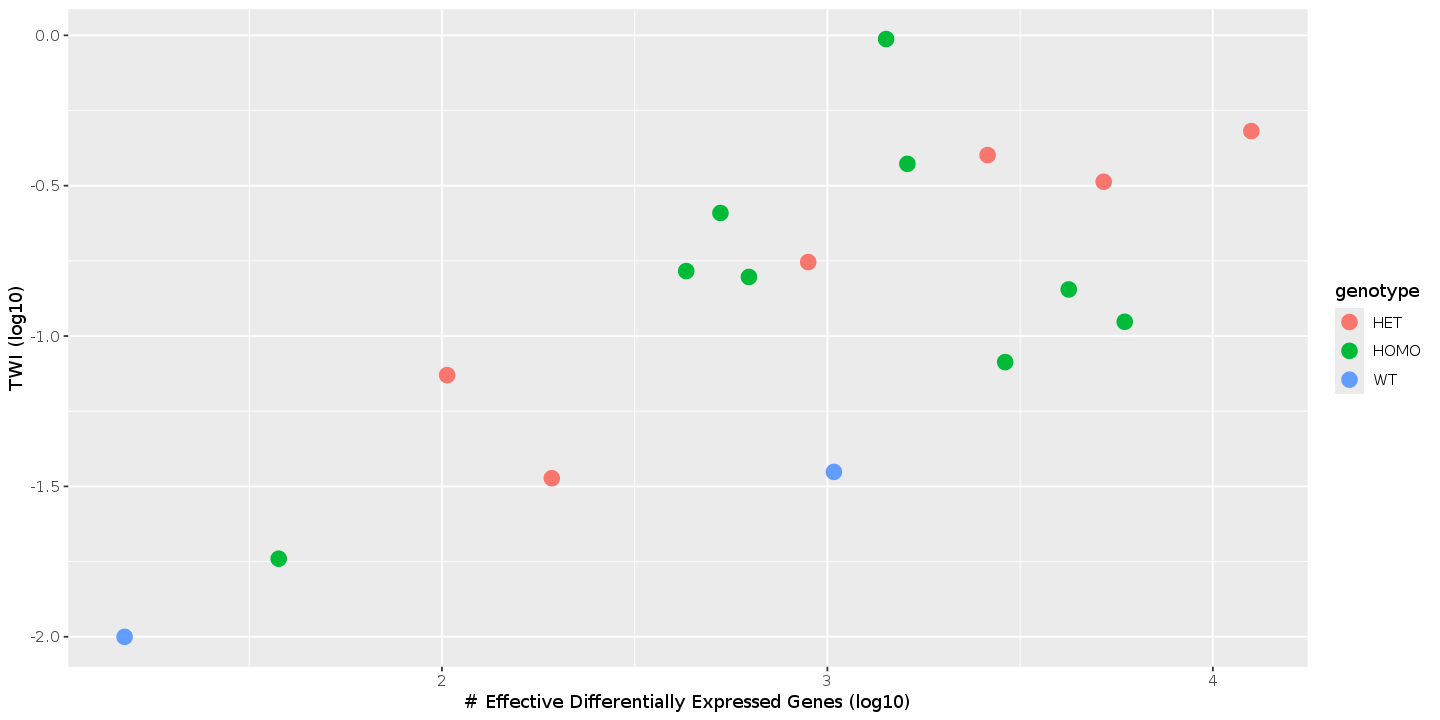

In [74]:
ggplot(TRADE_out_df,aes(x=log10(Me),y=log10(transcriptome_wide_impact),color=genotype)) +
    geom_point(size=4) +
    labs(x="# Effective Differentially Expressed Genes (log10)", y="TWI (log10)")

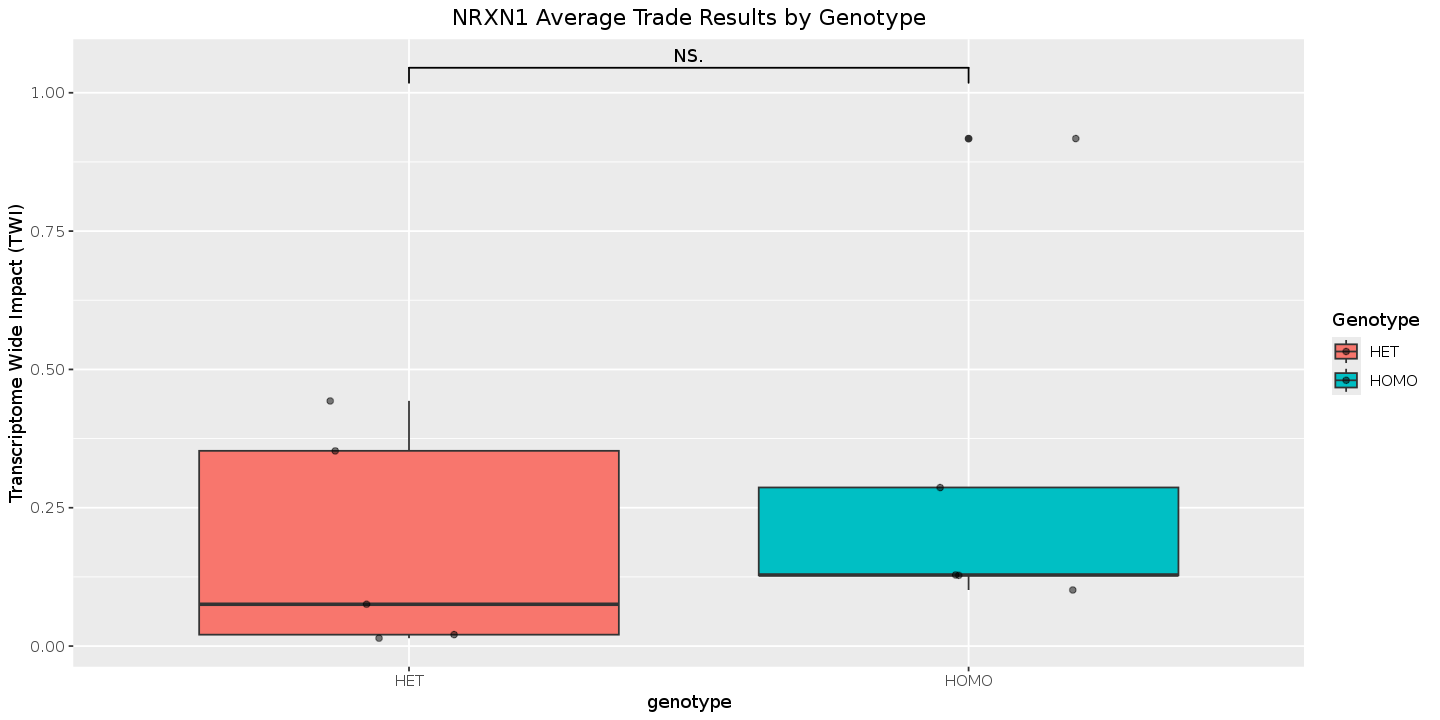

In [83]:
library(ggpubr)

comparisons_list <- list(#c('HIGH', 'LOW'), c('HIGH', 'NEUTRAL'), c('LOW', 'NEUTRAL'))
                      c('HET', 'HOMO'))
                      #c('Female', 'Male'))

# Calculate average TWI for each genotype
avg_data <- TRADE_out_df %>%
  group_by(genotype) %>%
  summarize(avg_TWI = mean(transcriptome_wide_impact, na.rm = TRUE), .groups = 'drop')

# Create boxplots with jitter
p <- ggplot(TRADE_out_df, aes(x = genotype, y = transcriptome_wide_impact, fill = genotype)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(y = "Transcriptome Wide Impact (TWI)", fill = "Genotype", title = "NRXN1 Average Trade Results by Genotype") +
  theme(plot.title = element_text(hjust = 0.5))

# Add statistical significance
p + geom_signif(comparisons = comparisons_list, 
                 map_signif_level = TRUE, 
                 y_position = c(1, 1.2, 1.4))

Warning message:
"Computation failed in `stat_signif()`.
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"


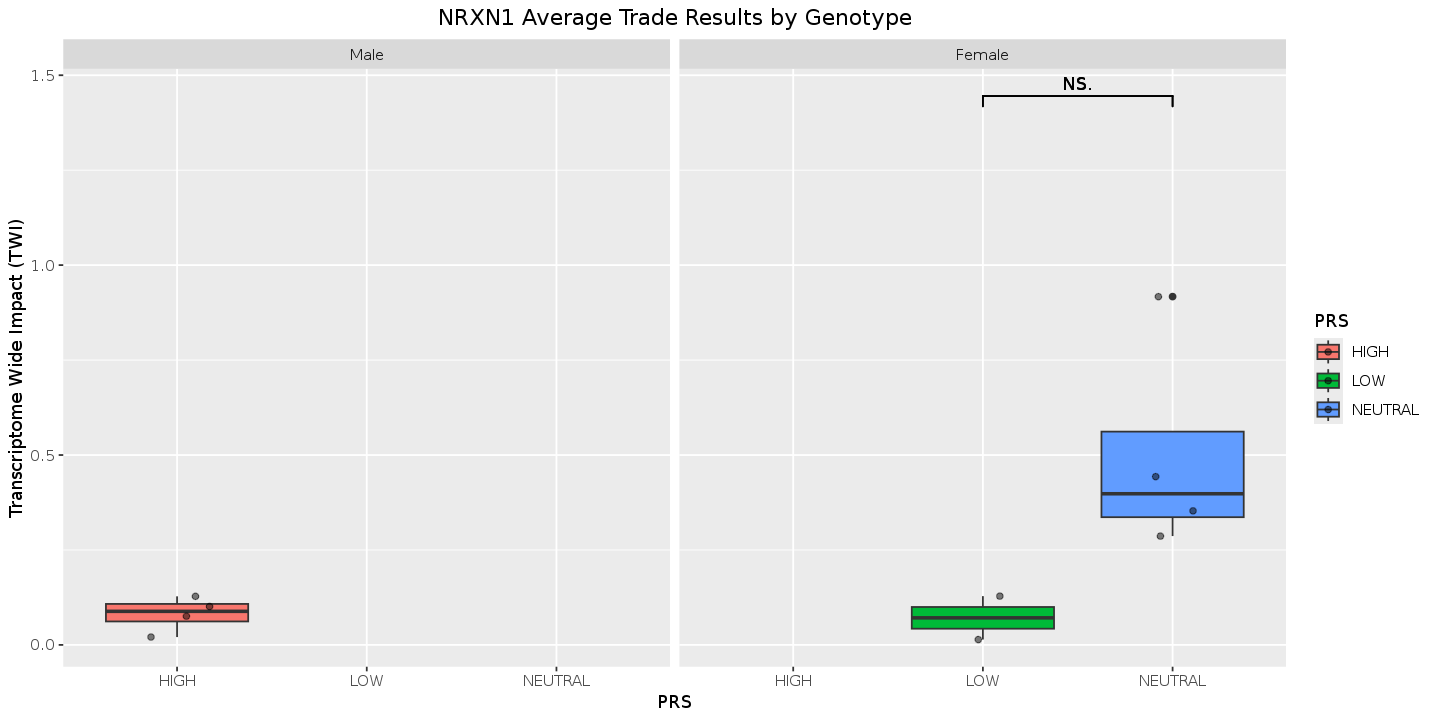

In [85]:
library(ggpubr)

# Define comparisons for genotype differences within each sex
comparisons_list <- #list(c("HOMO", "HET"), c("HOMO", "HET"))  # Will be mapped by sex 
list(c('HIGH', 'LOW'), c('HIGH', 'NEUTRAL'), c('LOW', 'NEUTRAL'), c('HIGH', 'LOW'), c('HIGH', 'NEUTRAL'), c('LOW', 'NEUTRAL'))

# Create boxplots with jitter, mapping genotype and sex
p <- ggplot(TRADE_out_df, aes(x = PRS, y = transcriptome_wide_impact, fill = PRS)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(y = "Transcriptome Wide Impact (TWI)", fill = "PRS", title = "NRXN1 Average Trade Results by Genotype") +
  theme(plot.title = element_text(hjust = 0.5)) +
  facet_wrap(~ sex)  # Facet by sex

# Add statistical significance, ensuring to adjust for each facet
p + geom_signif(comparisons = comparisons_list,
                 map_signif_level = TRUE,
                 y_position = c(1, 1.2, 1.4, 1, 1.2, 1.4))
                 #y_position = max(TRADE_out_df$transcriptome_wide_impact, na.rm = TRUE) + 0.5,
                 #position = position_dodge(0.75))  # Adjust position to avoid overlap

In [ ]:
TRADE_out_df

donor,mean,transcriptome_wide_impact,Me,KD,target,PRS,sex,genotype
<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
CW20012,2.439318e-02,0.176190923,891.54625,0,CW20012.NRXN1_HET,HIGH,Female,HET
CW20012,5.225989e-02,0.399773576,2603.55455,1,CW20012.NRXN1_HOMO,HIGH,Female,HOMO
CW20103,1.932021e-03,0.035331934,1039.64447,1,CW20103.NRXN1_HOMO,NEUTRAL,Female,HOMO
CW30154,5.636151e-03,0.009991955,15.01811,1,CW30154.NRXN1_HOMO,LOW,Female,HOMO
CW50037,-2.082726e-02,0.157178724,625.71216,1,CW50037.NRXN1_HOMO,NEUTRAL,Female,HOMO
ML6112911,-1.655842e-06,0.111548011,5906.62505,0,ML6112911.NRXN1_HOMO,NEUTRAL,Male,HOMO
ML6113363,-3.483774e-02,0.142866882,4227.74807,1,ML6113363.NRXN1_HOMO,HIGH,Male,HOMO
ML6113363,-2.638590e-02,0.081901277,2891.83326,1,ML6113363.NRXN1_HET,HIGH,Male,HET
ML8984425,2.325386e-02,0.164466419,430.25435,1,ML8984425.NRXN1_HOMO,LOW,Female,HOMO
